In [1]:
import pandas as pd
import numpy as np
import os
import sys
import json

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import torch

In [815]:
from scipy.ndimage import median_filter

In [4]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [5]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [16]:
from pickle import load

In [497]:
from tqdm import tqdm

In [6]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [439]:
from sklearn.metrics import silhouette_score

In [981]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')
feature_cols = [c for c in data.columns if "_" in c]
for col in feature_cols:
    data[col] = data[col].clip(data[col].mean() - (3*data[col].std()), data[col].mean() + (3*data[col].std()))

In [982]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, 128)
        
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 128)
        self.l4 = nn.Linear(128, embed_dim)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.dropout(x)
        x = self.relu(self.l2(x))
        x = self.dropout(x)
        x = self.relu(self.l3(x))
        x = self.dropout(x)
        x = self.l4(x)
        return x


class ClassificationHead(nn.Module):
    def __init__(self,embed_dim, output_dim):
        super().__init__()
        self.l1 = nn.Linear(embed_dim, 64)
        self.l2 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        return x

class UserClassifier(nn.Module):
    def __init__(self, input_dim, embed_dim, output_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, embed_dim)
        self.decoder = ClassificationHead(embed_dim, output_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [983]:
train_parts = list(range(1,39))
test_parts = list(range(39,44))

In [984]:
train_df = data[data["participant"].isin(train_parts)].reset_index()
test_df = data[data["participant"].isin(test_parts)].reset_index()

In [985]:
train_df[train_df['participant']==38]

,index,session,trial,filename,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
3689,3689,1,1,E:\DS5500-project\data\gesture-recognition-and...,6.097550,0.010836,0.000144,12371.193565,216.439454,1.565554,...,0.023124,-0.604704,3.521945,5.475507,0.032126,1.526150e-11,71.764268,10.0,10,38
3690,3690,1,2,E:\DS5500-project\data\gesture-recognition-and...,3.760940,0.007956,0.000080,-3420.068344,143.835930,0.365443,...,0.016505,-0.670116,2.811054,2.789468,0.014691,2.806150e-12,52.913961,16.0,10,38
3691,3691,1,3,E:\DS5500-project\data\gesture-recognition-and...,7.576713,0.012106,0.000180,4377.657015,213.549406,5.228293,...,0.018901,-0.811233,4.339130,3.658076,0.023372,9.917207e-12,53.501625,18.0,10,38
3692,3692,1,4,E:\DS5500-project\data\gesture-recognition-and...,7.020065,0.013158,0.000217,11454.240984,234.040882,2.492734,...,0.022456,-0.457721,2.896976,5.163879,0.034600,1.487831e-11,66.079424,8.0,10,38
3693,3693,1,5,E:\DS5500-project\data\gesture-recognition-and...,6.176605,0.009042,0.000101,-1311.915635,176.321696,1.490861,...,0.021580,-0.616602,4.893843,4.768511,0.023374,1.171588e-11,59.497298,2.0,10,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12847,14037,3,3,E:\DS5500-project\data\gesture-recognition-and...,5.425676,0.007644,0.000072,-2236.055273,151.828566,0.444445,...,0.033618,-0.339034,3.016555,11.572723,0.023638,7.482219e-12,77.835172,3.0,9,38
12848,14038,3,4,E:\DS5500-project\data\gesture-recognition-and...,6.849459,0.008394,0.000086,-2701.659876,160.975263,3.587046,...,0.031737,-0.093512,4.597554,10.313970,0.024326,1.076574e-11,74.406662,1.0,9,38
12849,14039,3,5,E:\DS5500-project\data\gesture-recognition-and...,5.474257,0.006846,0.000058,-1021.633119,132.847093,0.846615,...,0.036801,-0.220081,3.042451,13.868536,0.025805,9.606238e-12,87.383690,0.0,9,38
12850,14040,3,6,E:\DS5500-project\data\gesture-recognition-and...,4.102621,0.006895,0.000058,1741.911556,142.625808,0.445779,...,0.038768,-0.152836,3.123313,15.390149,0.027547,1.040902e-11,86.633790,1.0,9,38


In [986]:
scaler  = load(open('sub_scaler.pkl', 'rb'))

In [987]:
x_train = train_df.loc[:, feature_cols].values
y_train = (train_df.loc[:, 'participant']).values
g_train = (train_df.loc[:, 'gesture']).values
s_train = (train_df.loc[:, 'session']).values

In [988]:
x_test = test_df.loc[:, feature_cols].values
y_test = (test_df.loc[:, 'participant']).values
g_test = (test_df.loc[:, 'gesture']).values
s_test = (test_df.loc[:, 'session']).values

In [989]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [990]:
# s_test.shape

In [991]:
# x_test

In [992]:
encoder = Encoder(x_train.shape[1], 16)

In [993]:
encoder.load_state_dict(torch.load('sub_encoder.pth'), strict=False)

<All keys matched successfully>

In [994]:
def embed(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            # _, predicted = torch.max(outputs, 1)
            y_pred.extend(outputs)

    return torch.stack(y_pred)

In [995]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [996]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [997]:
train_embeddings = embed(model=encoder, test_loader=train_loader)
test_embeddings = embed(model=encoder, test_loader=test_loader)

In [998]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38], dtype=int64)

### Filter by gesture

In [1016]:
test_gesture = 11

In [1017]:
x_train

array([[ 0.77424686,  0.22894734, -0.03866896, ..., -0.19950481,
        -0.31648044,  0.22265155],
       [ 3.69577121,  0.39224843,  0.05191967, ..., -0.20265817,
        -0.59221924,  0.63944318],
       [ 1.4581732 , -0.22591701, -0.34523522, ..., -0.23473801,
        -0.53345128,  0.11845365],
       ...,
       [-0.0605876 , -0.03818827, -0.25518059, ..., -0.24191147,
        -0.49717514, -0.55883275],
       [ 0.32770657, -0.26345926, -0.38308866, ..., -0.25367637,
        -0.92542558, -0.55883275],
       [ 0.23102655, -0.21357721, -0.3526431 , ..., -0.24997502,
        -0.84327682, -0.35043694]])

In [1018]:
i = np.where(g_train == test_gesture)
train_feats = np.squeeze(train_embeddings[i,:])
train_labels = y_train[i]
train_sessions = s_train[i]

In [1019]:
i = np.where(g_test == test_gesture)
test_feats = np.squeeze(test_embeddings[i,:])
test_labels = y_test[i]
test_sessions = s_test[i]

### Visualize

#### Train

In [1020]:
sub_parts = [15,16,20,23,35,4,8,33,12,27]

In [1021]:
train_tsne = TSNE()
train_t_feats = train_tsne.fit_transform(train_feats)

In [1022]:
plot_df = pd.DataFrame({"x": train_t_feats[:,0], "y": train_t_feats[:,1], 
                        "participants": train_labels, "sessions":train_sessions})

In [1023]:
sub_plot = plot_df[plot_df['participants'].isin(sub_parts)]
sub_plot["participants"] = "p_" + sub_plot["participants"].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'T-SNE Visualization of feature space of training data in 2D - gesture 11')

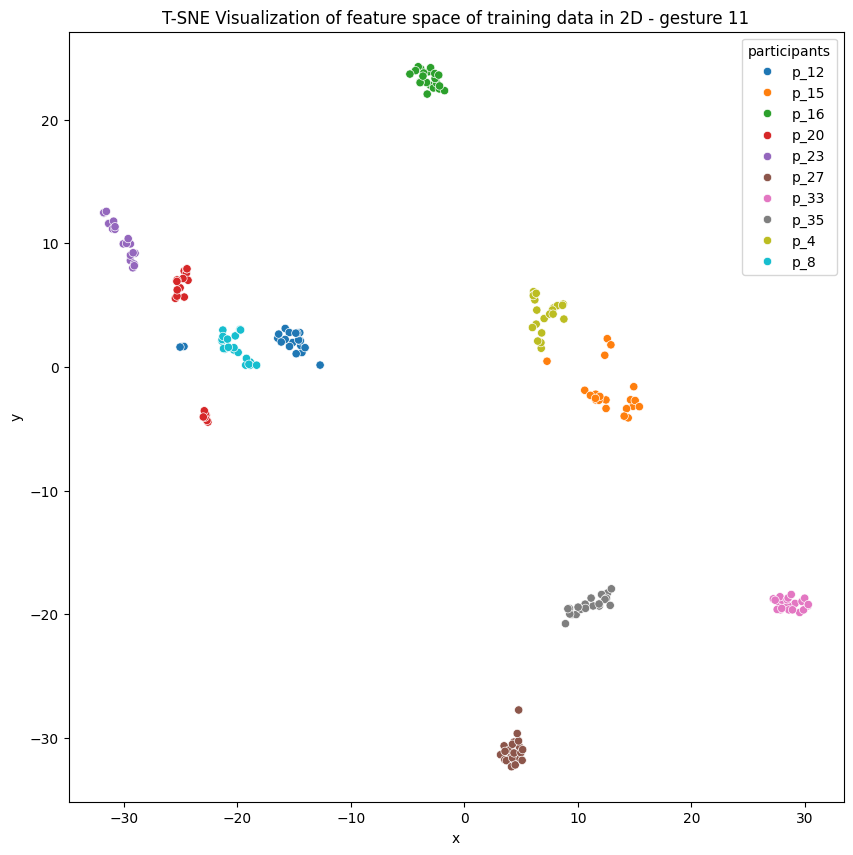

In [1024]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
                hue = "participants", 
                hue_order=sub_plot['participants'].unique(), ax = ax)
ax.set_title("T-SNE Visualization of feature space of training data in 2D - gesture 11")

#### Test

In [1025]:
sub_parts = [39,40,41,42,43]

In [1026]:
test_tsne = TSNE()
test_t_feats = test_tsne.fit_transform(test_feats)

In [1027]:
# test_t_feats = train_tsne.fit_transform(test_feats)

In [1028]:
test_feats.shape

torch.Size([105, 16])

In [1029]:
test_feats.shape

torch.Size([105, 16])

In [1030]:
plot_df = pd.DataFrame({"x": test_t_feats[:,0], "y": test_t_feats[:,1], 
                        "participants": test_labels, "sessions":test_sessions})

In [1031]:
sub_plot = plot_df[plot_df['participants'].isin(sub_parts)]
sub_plot["participants"] = "p_" + sub_plot["participants"].astype(str)

Text(0.5, 1.0, 'T-SNE Visualization of feature space of test data in 2D - gesture 11')

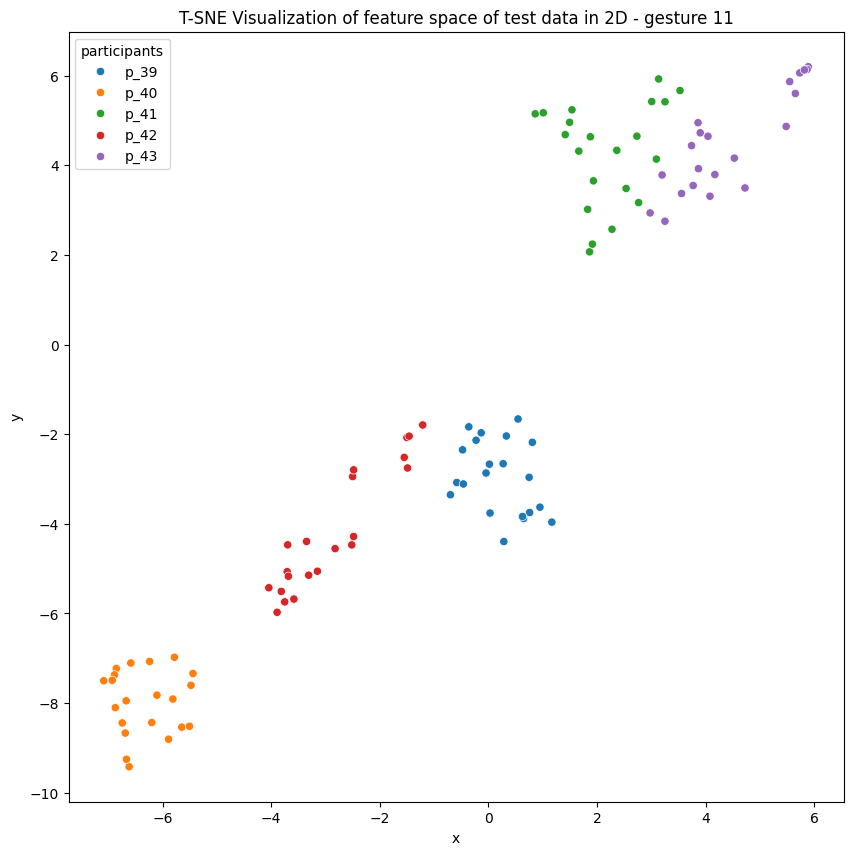

In [1032]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
                hue = "participants", 
                hue_order=sub_plot['participants'].unique(), ax = ax)
ax.set_title("T-SNE Visualization of feature space of test data in 2D - gesture 11")

### Check clustering on training set

In [717]:
train_tsne = TSNE()
train_t_feats = train_tsne.fit_transform(train_feats)

In [718]:
dbs = DBSCAN(eps=2)

In [719]:
clusters = dbs.fit_predict(train_t_feats, )

In [720]:
clusters

array([ 0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
        5,  6,  6,  6,  6,  6,  6,  6,  7,  7, -1,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13,
       13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20,
       20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22,
       22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25,
       25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27,
       27, 27, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 30,
       30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 26, 26, 26, 26,
       26, 26, 26, 32, 32

In [721]:
sub_parts = [15,16,20,23,35,4,8]

In [722]:
plot_df = pd.DataFrame({"x": train_t_feats[:,0], "y": train_t_feats[:,1], 
                        "participants": train_labels, "sessions":train_sessions, "clusters":clusters})

In [723]:
sub_plot = plot_df[plot_df['participants'].isin(sub_parts)]
sub_plot["participants"] = "p_" + sub_plot["participants"].astype(str)
sub_plot["clusters"] = "c_" + sub_plot["clusters"].astype(str)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'T-SNE Visualization of feature space of training data in 2D - gesture 11')

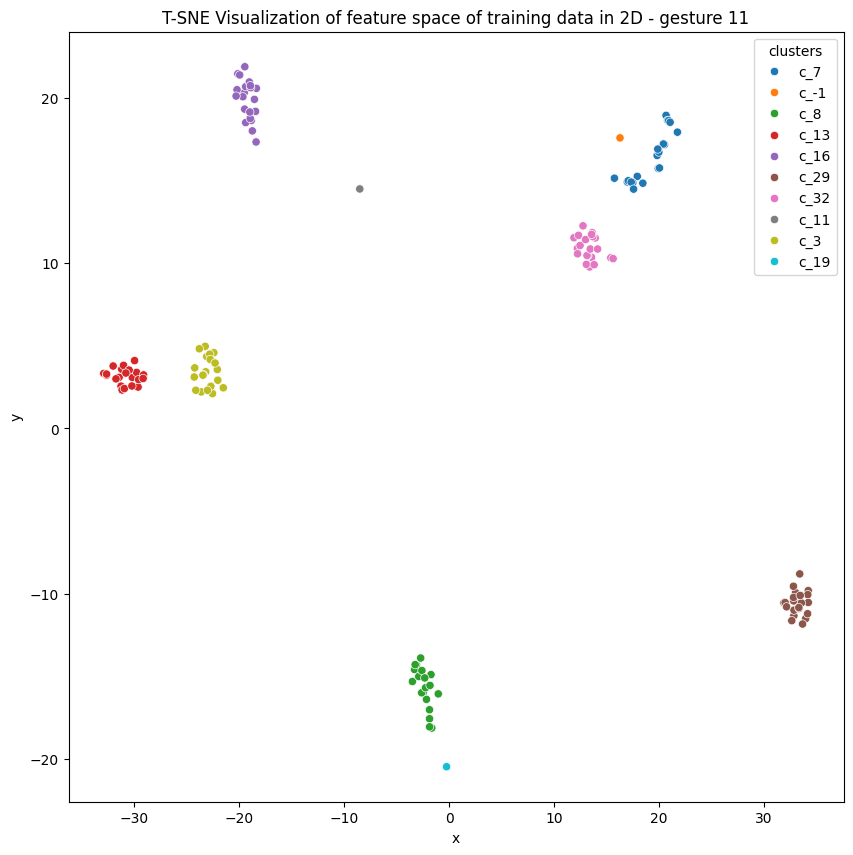

In [724]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
                hue = "clusters", 
                hue_order=sub_plot['clusters'].unique(), ax = ax)
ax.set_title("T-SNE Visualization of feature space of training data in 2D - gesture 11")

Text(0.5, 1.0, 'T-SNE Visualization of feature space of training data in 2D - gesture 11')

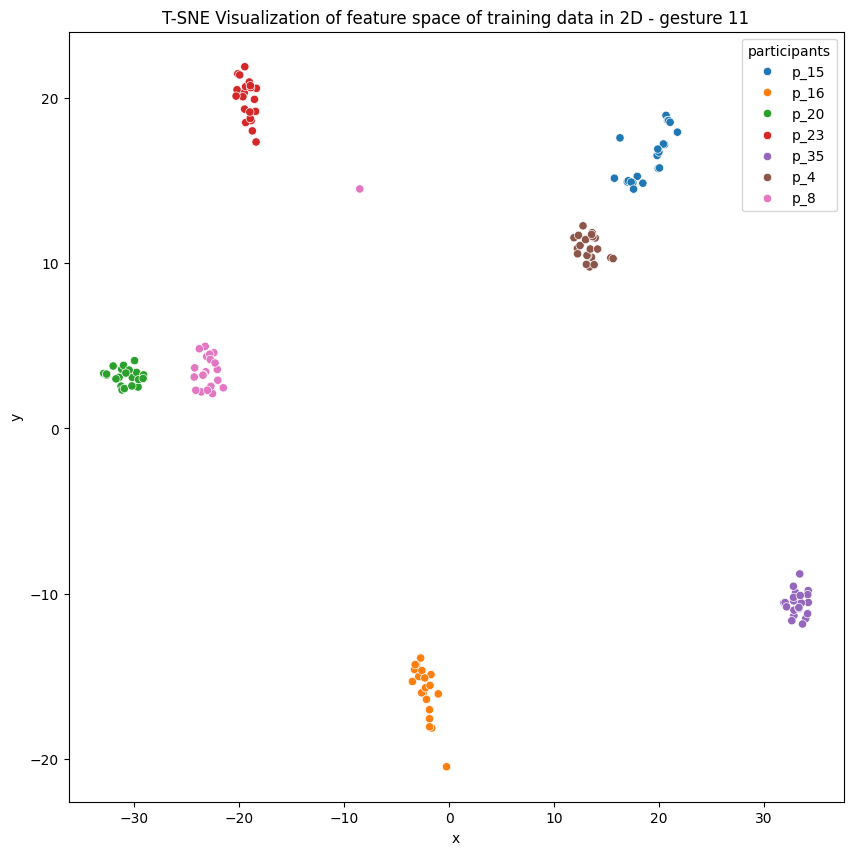

In [725]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data = sub_plot, x = "x", y = "y", 
                hue = "participants", 
                hue_order=sub_plot['participants'].unique(), ax = ax)
ax.set_title("T-SNE Visualization of feature space of training data in 2D - gesture 11")

### Get cluster distances for a gesture

In [884]:
parts = range(1,39)
gestures = range(1, 18)

In [885]:
def calculate_centroid(vectors):
    # if not vectors:
    #     return None  # Handle empty list

    # Convert the list of vectors to a NumPy array
    vectors_array = np.array(vectors)

    # Calculate the centroid by taking the mean along each dimension
    centroid = np.mean(vectors_array, axis=0)

    return centroid

In [886]:
def get_distances(vectors, centroid):
    distances = np.linalg.norm(vectors - centroid, axis=1)
    return distances

In [911]:
def filter_outlier(vectors, threshold=2.8):
    vectors = np.array(vectors)
    z_scores = np.abs((vectors - vectors.mean(axis=0)) / vectors.std(axis=0))

    # Apply median filter to each dimension independently
    # filtered_vectors = np.apply_along_axis(median_filter, axis=0, arr=vectors, size=size)
    # print(z_scores.shape)
    overall_z_scores = np.max(z_scores, axis = 1)
    # Filter out vectors with Z-scores beyond the threshold
    filtered_vectors = vectors[overall_z_scores <= threshold]
    return filtered_vectors

In [912]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [913]:
z = abs((embs - embs.mean(axis=0))) / embs.std(axis=0)

In [934]:
i = np.where((y_train == 27)&(g_train==4))

In [935]:
embs = train_embeddings[i]

In [936]:
filter_outlier(embs).shape

(20, 16)

In [970]:
centroids = {}
for g in tqdm(gestures):
    centroids[g] = {}
    for p in parts:
        centroids[g][p] = {}
        i = np.where((y_train == p)&(g_train==g))
        embs = train_embeddings[i]
        embs = filter_outlier(embs)
        c = calculate_centroid(embs)
        c = [float(i) for i in c]
        centroids[g][p]['centroid'] = list(c)
        
        d = get_distances(embs, c)
        centroids[g][p]['d_mean'] = float(d.mean())
        centroids[g][p]['d_std'] = float(d.std())

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 65.89it/s]


In [940]:
##Tightest clusters
gesture_means = {g:0 for g in range(1,18)}
for g in centroids:
    for p in centroids[g]:
        gesture_means[g]+=centroids[g][p]["d_mean"]
gesture_std = {g:0 for g in range(1,18)}
for g in centroids:
    for p in centroids[g]:
        gesture_std[g]+=centroids[g][p]["d_std"]

In [941]:
gesture_means = {g: gesture_means[g]/17 for g in gesture_means.keys()}
gesture_std = {g: gesture_std[g]/17 for g in gesture_std.keys()}

In [942]:
{k: v for k, v in sorted(gesture_means.items(), key=lambda item: item[1])}

{17: 7.257551319458905,
 13: 10.049773707109338,
 14: 11.321919581469368,
 7: 11.638691214954152,
 4: 11.695144414901733,
 2: 11.89763233240913,
 3: 12.392235910191255,
 9: 12.637893718831679,
 16: 12.952464356141931,
 1: 13.025334049673642,
 10: 13.416890677283792,
 12: 13.527624158298268,
 6: 13.58771300315857,
 8: 13.66482187719906,
 15: 14.239655017852783,
 5: 14.438321884940652,
 11: 15.418548569959754}

In [943]:
{k: v for k, v in sorted(gesture_std.items(), key=lambda item: item[1])}

{17: 2.745041044319377,
 13: 4.2923617573345405,
 14: 4.762342488064485,
 7: 4.92064375035903,
 4: 5.010454297065735,
 3: 5.4352640895282525,
 9: 5.477421620312859,
 2: 5.509822049561669,
 6: 5.664395318311803,
 16: 5.790385428596945,
 12: 5.912513431380777,
 1: 5.994144380092621,
 8: 6.085611630888546,
 5: 6.254701530232149,
 10: 6.325140455189874,
 15: 6.340703690753264,
 11: 6.933804270099191}

In [969]:
type(centroids[1][1]['centroid'][0])

numpy.float32

In [971]:
with open("centroids_v1.json", "w") as file:
    json.dump(centroids, file)

In [960]:
type(centroids[1][2]['centroid'][0])

numpy.float32

In [973]:
test_parts = range(39,44)

In [974]:
test_centroids = {}
for g in tqdm(gestures):
    test_centroids[g] = {}
    for p in test_parts:
        test_centroids[g][p] = {}
        i = np.where((y_test == p)&(g_test==g))
        embs = test_embeddings[i]
        embs = filter_outlier(embs)
        c = calculate_centroid(embs)
        c = [float(i) for i in c]
        test_centroids[g][p]['centroid'] = list(c)
        
        d = get_distances(embs, c)
        test_centroids[g][p]['d_mean'] = float(d.mean())
        test_centroids[g][p]['d_std'] = float(d.std())

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 50.44it/s]


In [977]:
test_centroids[1]

{39: {'centroid': [0.6523360013961792,
   0.8988782167434692,
   2.9899301528930664,
   -2.142638683319092,
   0.1253279745578766,
   1.2779788970947266,
   0.5647120475769043,
   0.8438267707824707,
   -2.6435351371765137,
   -3.651057481765747,
   -0.10171715915203094,
   2.586277961730957,
   -3.375293016433716,
   4.154512405395508,
   0.034008316695690155,
   -2.815065860748291],
  'd_mean': 4.940178579648675,
  'd_std': 1.4127813635288438},
 40: {'centroid': [-2.049948215484619,
   -0.15646404027938843,
   1.0591182708740234,
   2.1663293838500977,
   3.456369400024414,
   2.2891550064086914,
   -3.2322559356689453,
   4.211279392242432,
   -6.117699146270752,
   -1.5544841289520264,
   -4.380134105682373,
   7.045485496520996,
   -4.444636344909668,
   2.9606475830078125,
   -3.5215840339660645,
   -7.139197826385498],
  'd_mean': 6.745694367056882,
  'd_std': 2.738773422524869},
 41: {'centroid': [1.1396187543869019,
   3.292293071746826,
   4.497869491577148,
   -4.40397644042

In [976]:
with open("test_centroids_v1.json", "w") as file:
    json.dump(test_centroids, file)

In [579]:
MotionName[4-1]

'Thumb and Index Finger Opposition'

In [580]:
MotionName[13-1]

'Forearm Supination'